In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [7]:
X_all = df[[feat for feat in df.columns if feat != "Diabetes_binary"]]
Y_all = df["Diabetes_binary"]

[Text(0, 0, '218334'), Text(0, 0, '35346')]

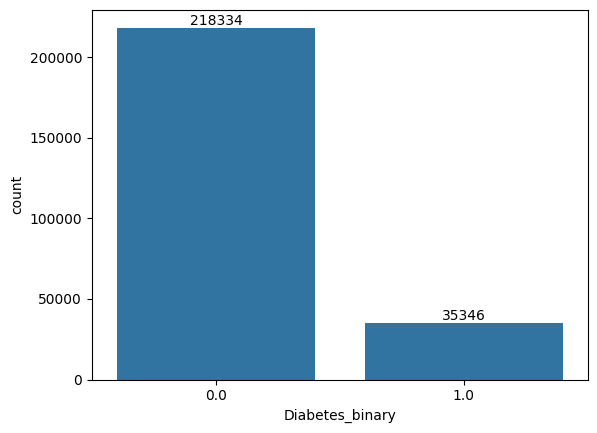

In [8]:
ax=sns.countplot(data=df, x="Diabetes_binary")
ax.bar_label(ax.containers[0])

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Dados reservados para validação final do modelo
X, X_test, Y, y_test = train_test_split(X_all, Y_all, test_size=0.1, random_state=416, stratify=Y_all)

[Text(0, 0, '196501'), Text(0, 0, '31811')]

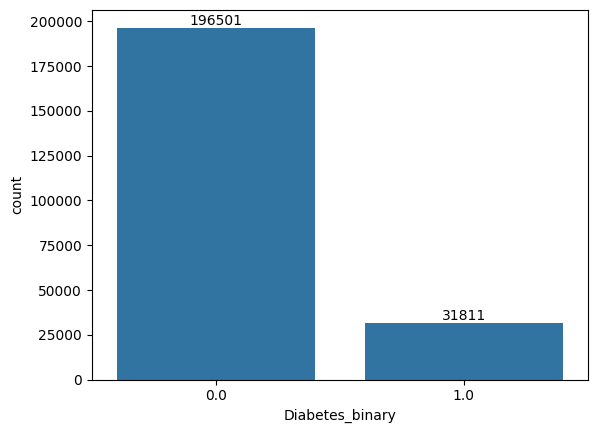

In [11]:
ax=sns.countplot(data=df.iloc[Y.index], x="Diabetes_binary")
ax.bar_label(ax.containers[0])

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


Fazendo testes de mudanças de parâmetros com auxílio de GridSearch

In [13]:
parameters = {'C':(0.01, .1,.5,1,5,10,100), 'penalty': ("l1", 'l2'),}

In [ ]:
classifier = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga')
gridsearch = GridSearchCV(classifier, parameters, cv=5, n_jobs=8, scoring="f1", verbose=0)
gridsearch.fit(X, Y)

In [ ]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by=["mean_test_score"], ascending=False,).head()

Avaliando cutoff ótimo

In [14]:
from tqdm import tqdm
from sklearn.metrics import f1_score, matthews_corrcoef, roc_curve, roc_auc_score, \
                            classification_report ,confusion_matrix,balanced_accuracy_score, recall_score, precision_score, precision_recall_curve

In [15]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [16]:
mccs, balan_accs, f1s, cms = [],[],[], []
precisions, recalls = [],[]
tprs, fprs, aucs = [], [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    clf = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga', C=0.01, penalty='l2', n_jobs=8)
    clf.fit(X_train, Y_train)
    y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, 0.5)[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    f1s.append(f1)
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds = precision_recall_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=False)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [49:04<00:00, 29.45s/it]


In [17]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7464 +- 0.0019
ROC-AUC: 0.8231 +- 0.0016
MCC: 0.3598 +- 0.0027
F1: 0.4436 +- 0.0019
Precision: 0.3122 +- 0.0015
Recall: 0.7660 +- 0.0042


<Axes: >

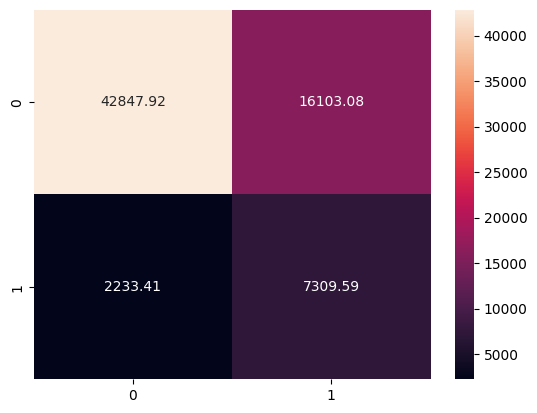

In [18]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

<Figure size 640x480 with 0 Axes>

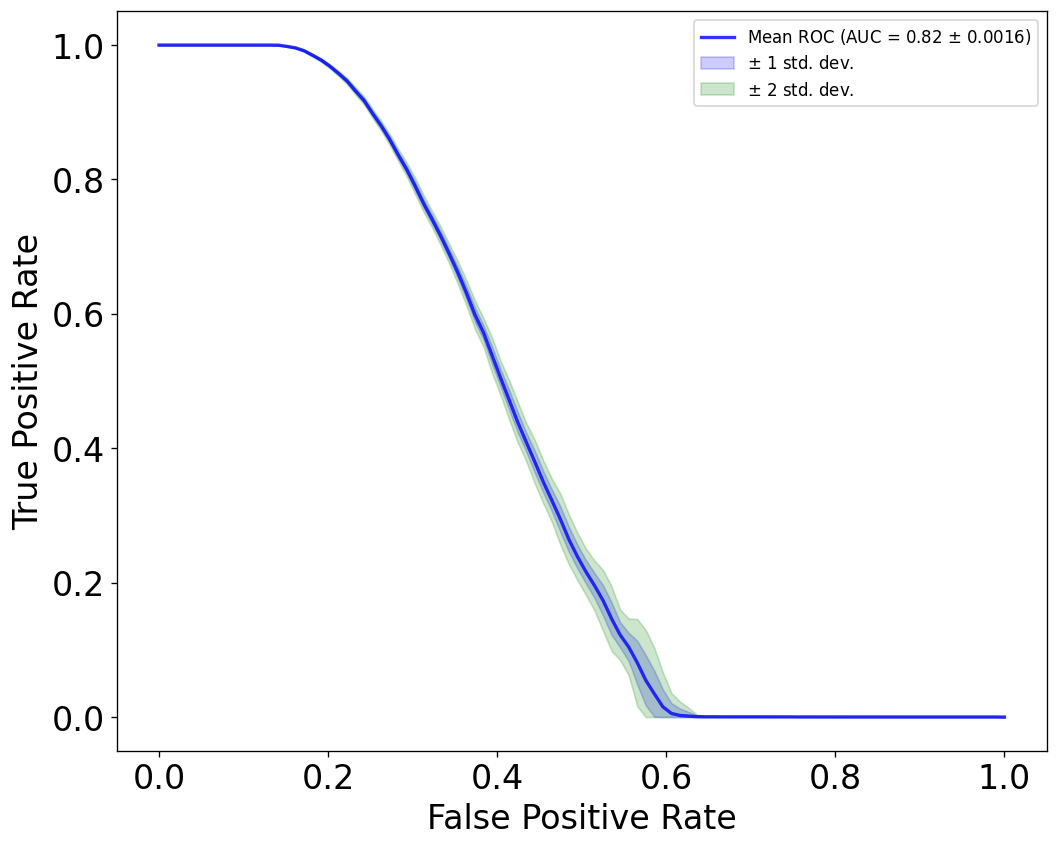

In [19]:
plt.figure()
# plt.style.use('seaborn-whitegrid')

lw = 2
plt.figure(figsize=(10, 8), dpi=120)

mean_tpr = np.mean(np.array(tprs), axis=0)
mean_fpr = np.linspace(0, 1, 100)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="blue",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr*2, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr*2, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="green",
    alpha=0.2,
    label=r"$\pm$ 2 std. dev.",
)

# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
# plt.title("Curva ROC", fontsize=20)
plt.legend(loc="upper right",prop={'size': 10})

Ajuste de cut-off point com F1-Score

In [20]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    clf = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga', C=0.01, penalty='l2', n_jobs=8)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [f1_score(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    # y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [26:38<00:00, 15.99s/it]


In [21]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7265 +- 0.0041
ROC-AUC: 0.8231 +- 0.0016
MCC: 0.3666 +- 0.0031
F1: 0.4619 +- 0.0025
Precision: 0.3644 +- 0.0072
Recall: 0.6316 +- 0.0177


In [22]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.6149


<Axes: >

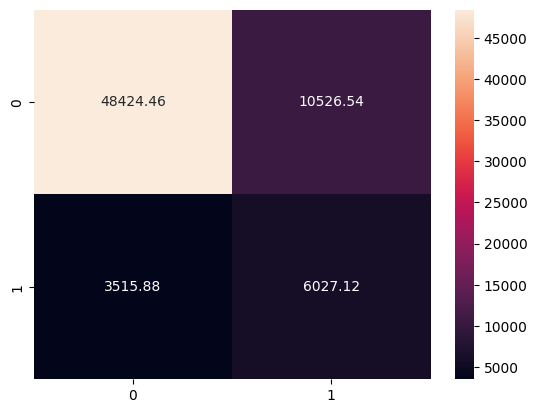

In [23]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

Ajuste de cut-off point com Acurácia Balanceada

In [24]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    clf = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga', C=0.01, penalty='l2', n_jobs=8)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [balanced_accuracy_score(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    # y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [29:16<00:00, 17.57s/it]


In [25]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7488 +- 0.0017
ROC-AUC: 0.8231 +- 0.0016
MCC: 0.3551 +- 0.0031
F1: 0.4338 +- 0.0032
Precision: 0.2965 +- 0.0040
Recall: 0.8081 +- 0.0090


In [26]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.4579000000000001


<Axes: >

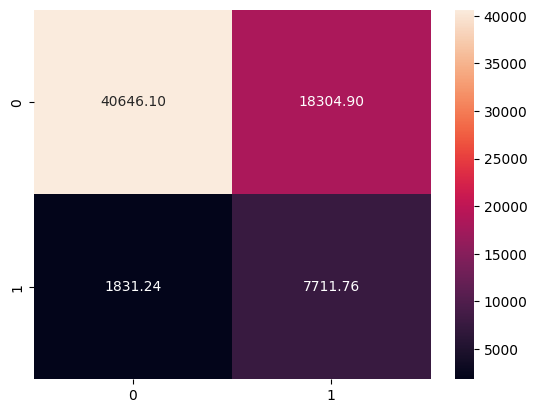

In [27]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

Ajuste de cut-off point com MCC

In [28]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    clf = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga', C=0.01, penalty='l2', n_jobs=8)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [matthews_corrcoef(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    # y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [41:00<00:00, 24.61s/it]


In [29]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7359 +- 0.0038
ROC-AUC: 0.8231 +- 0.0016
MCC: 0.3681 +- 0.0028
F1: 0.4602 +- 0.0031
Precision: 0.3490 +- 0.0080
Recall: 0.6764 +- 0.0201


In [30]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.5814000000000001


<Axes: >

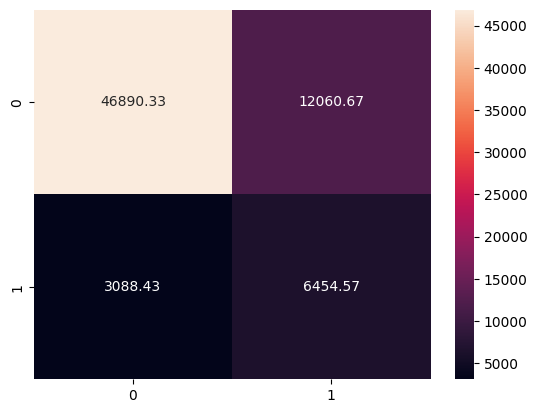

In [31]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")